# LANL Earthquake EDA and Prediction

## Content:
 - __Introduction__<br>
 - __Data Preparation__<br>
 - __Data Exploration and Analysis__<br>
 - __Summary__<br>
 - __References__<br>

## Introduction:



__Predicting the Earthquake is “THE” most important challenge in Earth Science because of its destructive nature and huge impact on social and economic damagesfor any country.This challenge is hosted by Los Alamos National Laboratory which enhances
national security by ensuring the safety of the U.S. nuclear stockpile, developing technologies to reduce threats from weapons of mass destruction, and solving problems related to energy, environment, infrastructure, health, and global security
concerns.__

In [25]:
#inporting the necessary libraries...
import pandas as pd
import numpy as np
import os
from tsfresh.feature_extraction import feature_calculators
import librosa
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join
from scipy import stats
from random import shuffle
import dask.dataframe as dd
import scipy.signal as sg
from tqdm import tqdm_notebook

# Data Preparation:

In [3]:
#lets load the file and take a look.
train= pd.read_csv(os.path.join('train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32},nrows=10000000)

In [10]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float32
dtypes: float32(1), int16(1)
memory usage: 57.2 MB


### Observations:
 - __acoustic_data: This is the signal measured in laboratory also known as sismic signal.__<br>
 - __time_to_failure: This is the time before laboratory eartehquake.__<br>

# Train Data Exploration:


### Distributioin Plot of Acoustic signal.

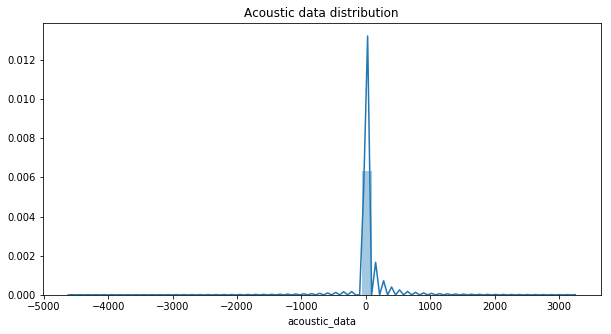

In [50]:
plt.figure(figsize=(10,5))
plt.title("Acoustic data distribution")
ax = sns.distplot(train.acoustic_data)

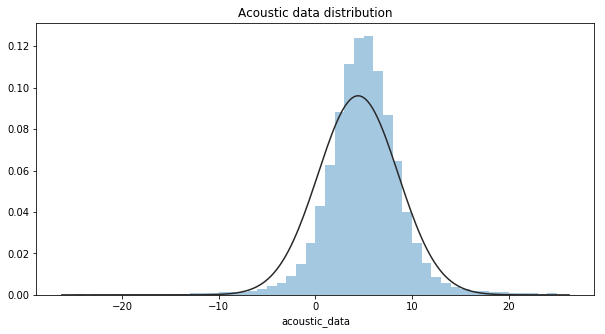

In [51]:
plt.figure(figsize=(10,5))
plt.title("Acoustic data distribution")
tmp = train_sample.acoustic_data[train.acoustic_data.between(-25, 25)]
ax = sns.distplot(tmp, kde=False, fit=stats.norm)

### Observations:
- __Acoustic signal is having outliers on both sides.__
- __Most of the data follows Normal distribution.__

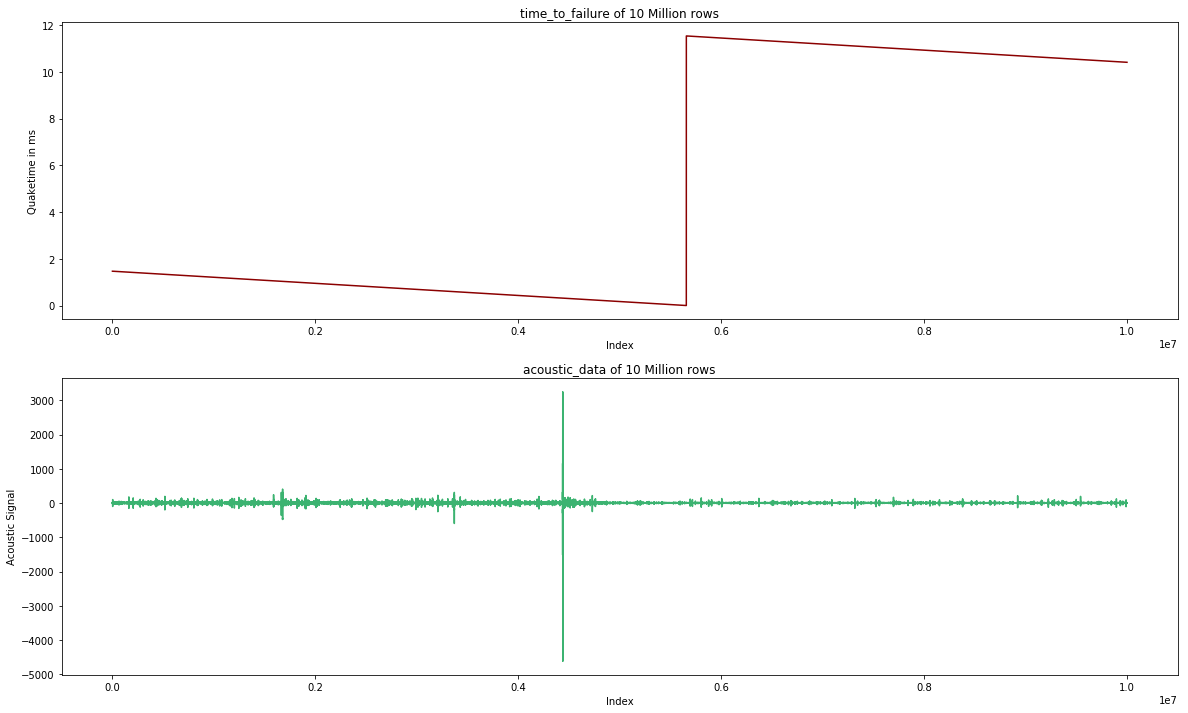

In [14]:
fig, ax = plt.subplots(2,1, figsize=(20,12))

ax[0].plot(train.index.values, train.time_to_failure.values, c="darkred")
ax[0].set_title("time_to_failure of 10 Million rows")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Quaketime in ms");

ax[1].plot(train.index.values, train.acoustic_data.values, c="mediumseagreen")
ax[1].set_title("acoustic_data of 10 Million rows")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Acoustic Signal");

### Observations:
 - __This ploting idea and code are taken from above mentioned link https://www.kaggle.com/allunia/shaking-earth__.
 - __This plot gives very a very good insight, this plot is for 10M rows and time_to_failure goes to zero only once this is the time when laboratory Earthquake occours__.
 - __second plot shows that there are many small osillations before large peak and  then again oscillations decreases__.

### Overlap plots for both acoustic signal and time to failure:

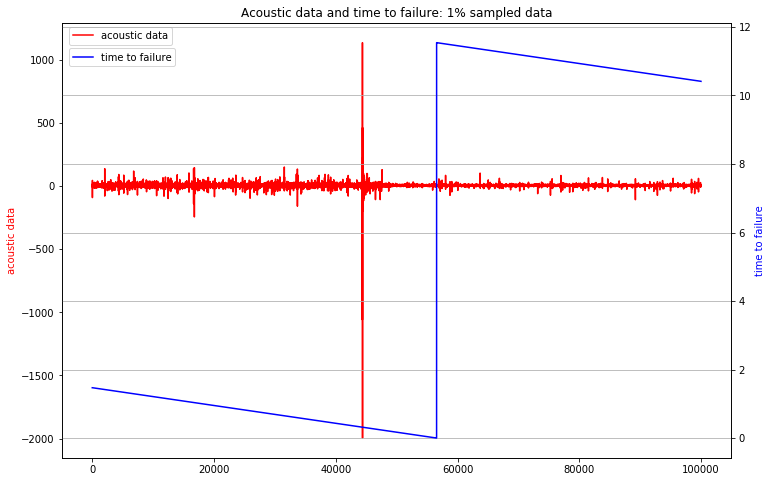

In [20]:
#plot for 1% of the data. For this we will sample every 100 points of data
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    
    ax2 = ax1.twinx()
    
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

## Observations:
 - __There are large oscillations just before earthquake.__<br>
 - __There are ossilations inbetween two successive earthquakes also.__
 - __Lets zoom in and see both signals. 1% of the data.__


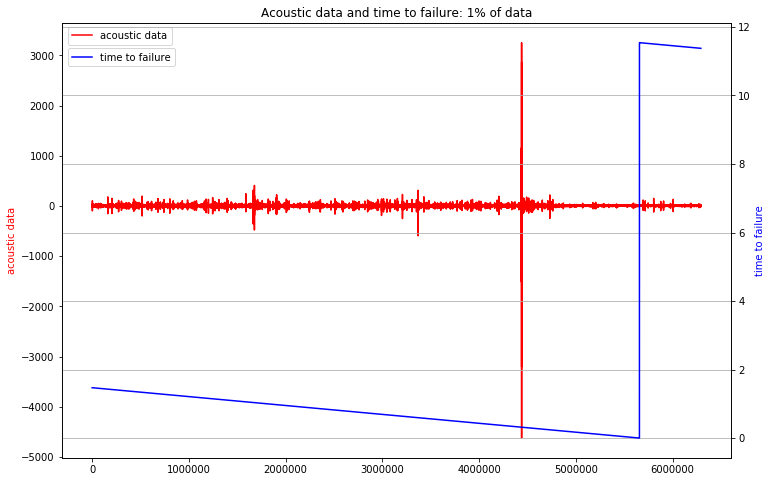

In [21]:
train_ad_sample_df = train['acoustic_data'].values[:6291455]
train_ttf_sample_df = train['time_to_failure'].values[:6291455]
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% of data")
del train_ad_sample_df
del train_ttf_sample_df

## Observations:
 - __acoustic data is having many large and small amplitude signals.__<br>
 - __earthquake occour after some minor oscillations thes minor oscillations occours occours after a large amplitude occoured.__

# Test Data Exploration:

In [3]:
test = [f for f in listdir("test") if isfile(join("test", f))]
print("There are {} test files in test folder.".format(len(test)))

There are 2624 test files in test folder.


### Test data Distribution plot:

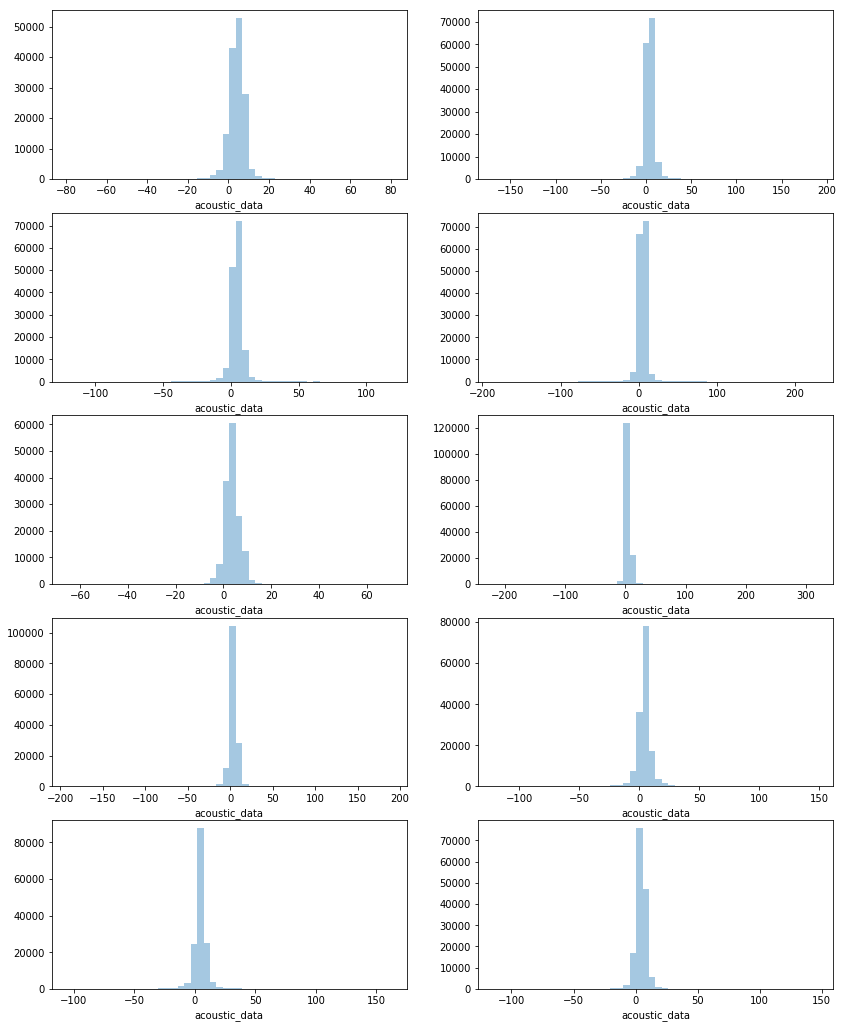

In [23]:
fig, axis = plt.subplots(5, 2, figsize=(14,18))
shuffle(test)
xrow = xcol = 0
for f in test[:10]:
    tmp = pd.read_csv('test/{}'.format(f), dtype='int16')
    ax = sns.distplot(tmp.acoustic_data, label=f.replace('.csv',''), ax=axis[xrow][xcol], kde=False)
    if xcol == 0:
        xcol += 1
    else:
        xcol = 0
        xrow += 1

## Observation:
- __we can say that there are very few outliers in test dataset files.__<br>
- __not perfectly but data shows some form of normal distribution.__<br>
- __lets zoom in and see how is the nature of distribution itself.__<br>
    

### Zoom-in for above diatribution plot:

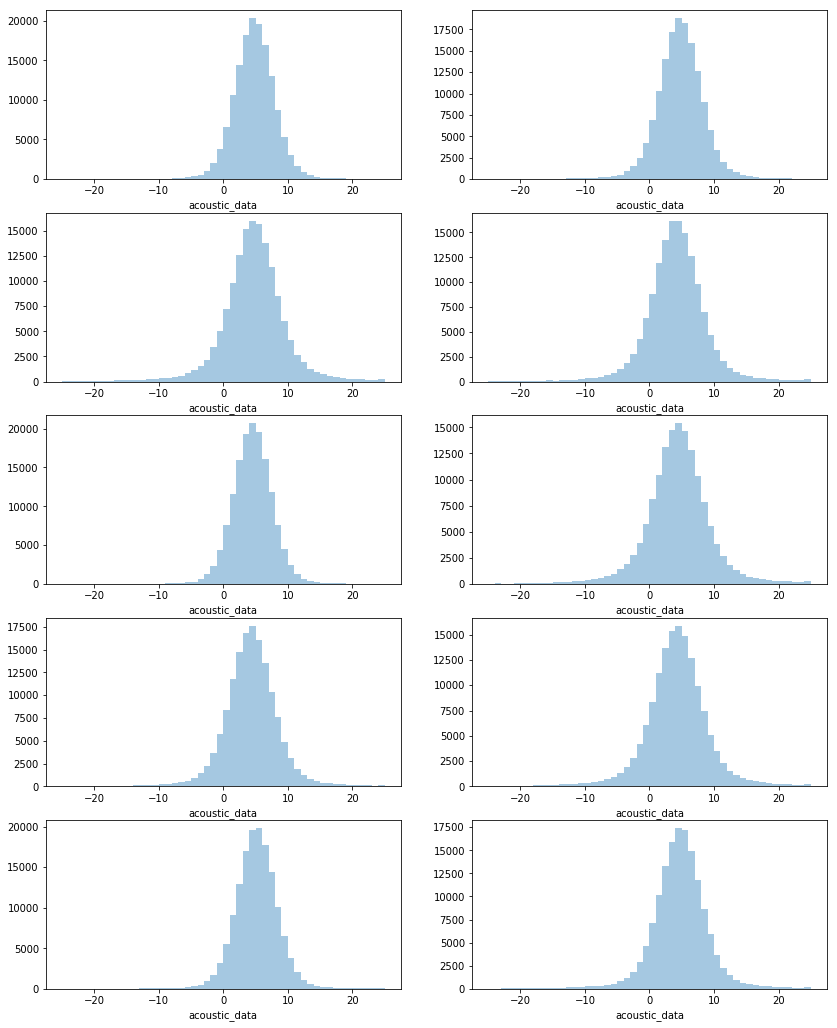

In [24]:
fig, axis = plt.subplots(5, 2, figsize=(14,18))
shuffle(test)
xrow = xcol = 0
for f in test[:10]:
    tmp = pd.read_csv('test/{}'.format(f), dtype='int16')
    ax = sns.distplot(tmp.acoustic_data[tmp.acoustic_data.between(-25, 25)], label=f.replace('.csv',''), ax=axis[xrow][xcol], kde=False)
   # tmp = train_sample.acoustic_data[train_sample.acoustic_data.between(-25, 25)]
    if xcol == 0:
        xcol += 1
    else:
        xcol = 0
        xrow += 1

### BoxPlot for above Ranged plot:

In [13]:
ld = os.listdir("test")#it will list all files in test folder.
sizes = np.zeros(len(ld))


array([0., 0., 0., ..., 0., 0., 0.])

In [8]:
#lets check the dile size:
ld = os.listdir("test")#it will list all files in test folder.
sizes = np.zeros(len(ld))#list of zeros with length of 2624.

#we will itrate through list.list is having index and values in it.

for i, f in enumerate(ld):
    df = pd.read_csv(os.path.join("test",f))
    sizes[i] = df.shape[0]

print(np.mean(sizes))  # all were 150,000
print(np.min(sizes))
print(np.max(sizes))

150000.0
150000.0
150000.0


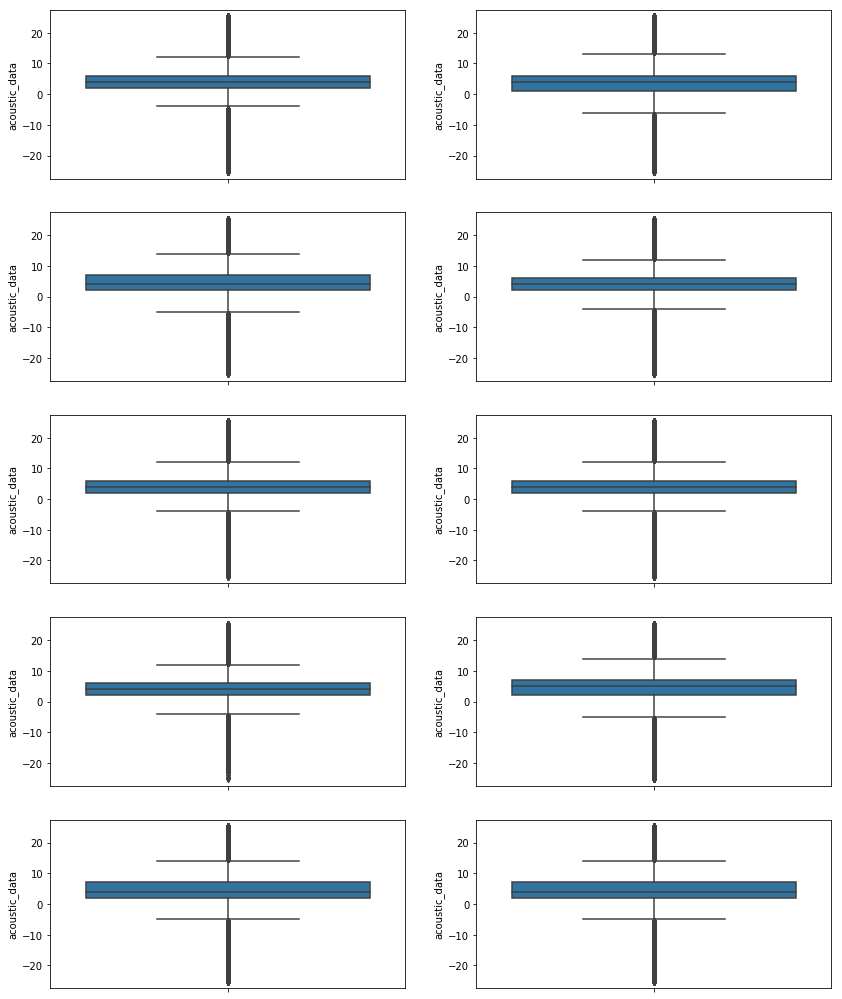

In [26]:
fig, axis = plt.subplots(5, 2, figsize=(14,18))#sub plots of 5x2 columns.
shuffle(test)#shufle test data.
xrow = xcol = 0
for f in test[:10]:
    tmp = pd.read_csv('test/{}'.format(f), dtype='int16')
    ax = sns.boxplot(y=tmp.acoustic_data[tmp.acoustic_data.between(-25,25)],ax=axis[xrow][xcol])
   # tmp = train_sample.acoustic_data[train_sample.acoustic_data.between(-25, 25)]
    if xcol == 0:
        xcol += 1
    else:
        xcol = 0
        xrow += 1

### Observation:
 - __The plots seems to be uniformly distributed and also have outliers.__<br>
 - __All files are showing same distribution.__<br>

### Observation:
 - __This shows that all files of test folder are 150K size.__<br>
    

### Plot Test Signals.

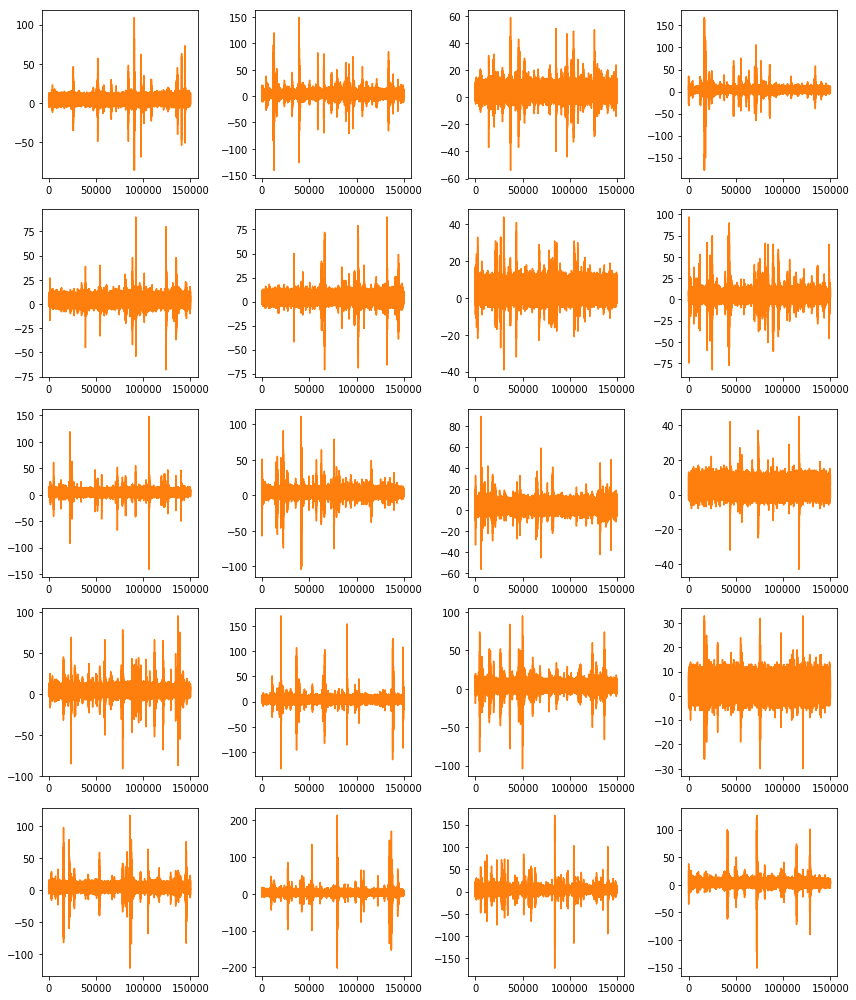

In [27]:
fig, axes = plt.subplots(5,4, figsize=(12,14))
i=0
j=0
for sig_file in test[:20]:
    sig = pd.read_csv('test/{}'.format(sig_file), dtype='int16')
    axes[j][i].plot(sig, color='tab:orange')
    
    i += 1
    if i >= 4:
        i = 0
        j += 1

plt.tight_layout()
plt.show()
del sig

### Obsevation:
 - __Since the test signal ae of size 150K data points we will plot the file with same size.__<br>
 - __The above plots are showing the time domain plot of individual files of test folder.__<br>
 - __The plots showing many high and low amplitude components,to predict the output correctly the test signal and train signal characteristic should match.__<br>
 

In [3]:
window_sizes = [10, 50, 100, 1000]
for window in window_sizes:
    train["rolling_mean_" + str(window)] = train.acoustic_data.rolling(window=window).mean()
    train["rolling_std_" + str(window)] = train.acoustic_data.rolling(window=window).std()

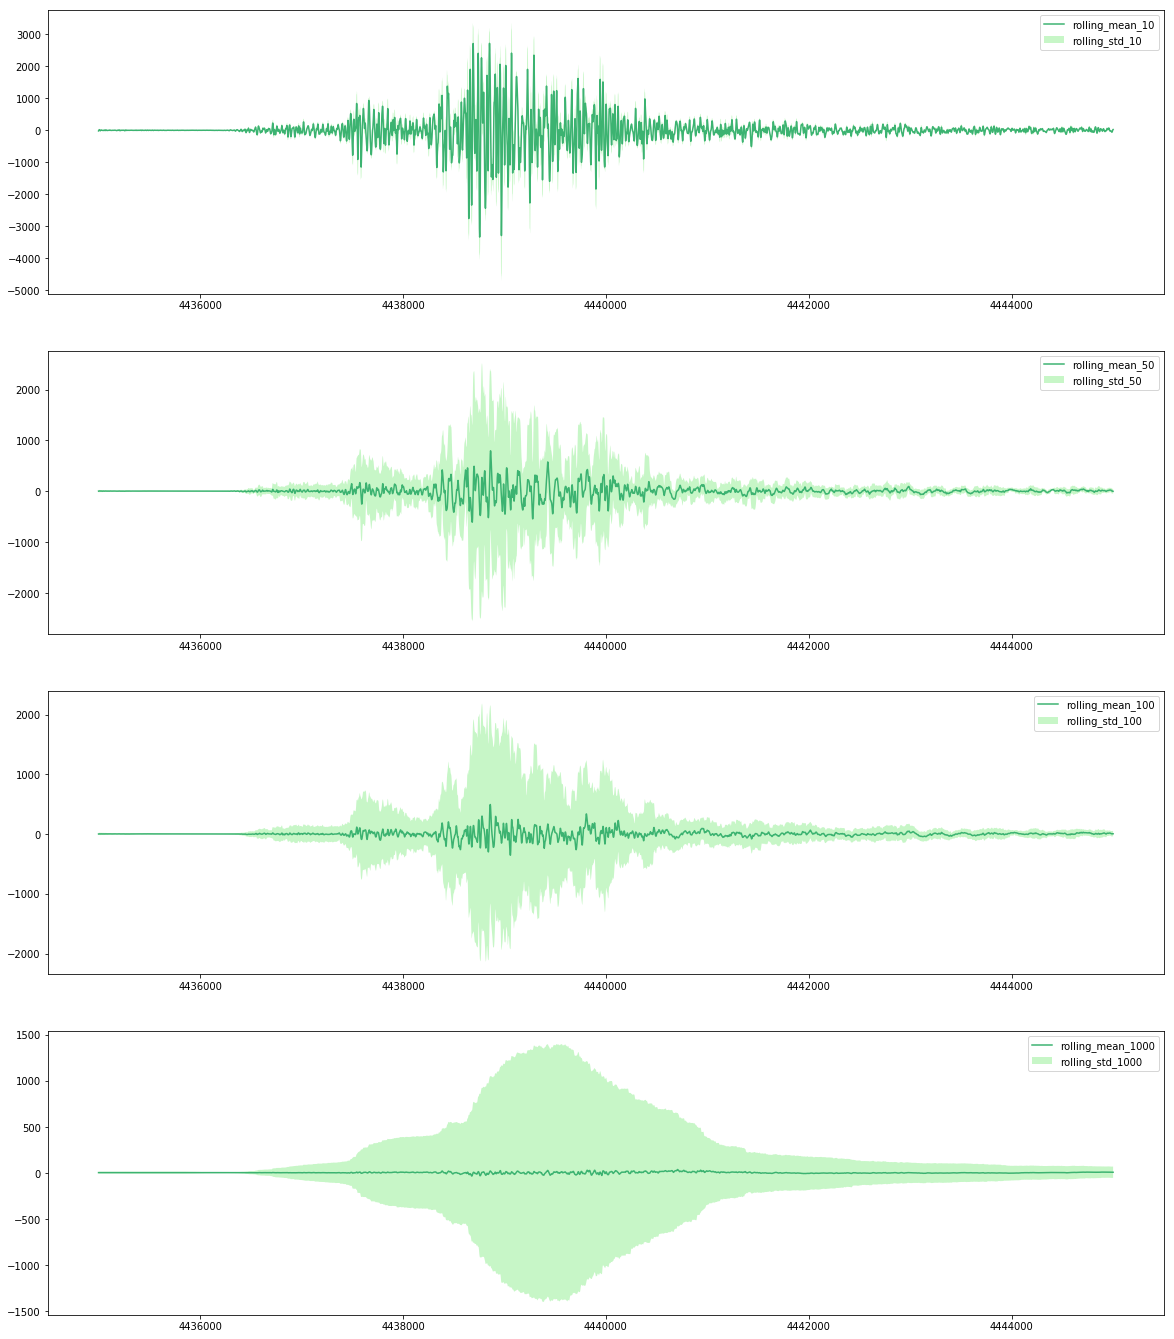

In [5]:
#this code is taken from https://www.kaggle.com/allunia/shaking-earth
fig, ax = plt.subplots(len(window_sizes),1,figsize=(20,6*len(window_sizes)))

n = 0
for col in train.columns.values:
    if "rolling_" in col:
        if "mean" in col:
            mean_df = train.iloc[4435000:4445000][col]
            ax[n].plot(mean_df, label=col, color="mediumseagreen")
        if "std" in col:
            std = train.iloc[4435000:4445000][col].values
            ax[n].fill_between(mean_df.index.values,
                               mean_df.values-std, mean_df.values+std,
                               facecolor='lightgreen',
                               alpha = 0.5, label=col)
            ax[n].legend()
            n+=1

# Observation:
- __window size of 50 is covering most of the fluctuations.__<br>

## Summnary:
- __The major observation is that the train data and test datasets are having different distribution.this is not desirable.if we perform the modelling on such data then we will not be able to predict the right values for test dataset.__<br>
- __We need to prepare the train dataset such that the distribution for both test and train will be approximatly similar to each other.__<br>
- __Since the dataset is having only Acoustic signal we will need to extract the features keeping it in mind.__<br>
- __Statistical features will be very benificial to do the predicting of time to failure.__<br>
    - __Peak value features.__<br>
    - __Simple aggregation features. mean,median,mim,max.__<br>
    - __since acoustic signal is time dependent we will use moving window features.__<br>
    - __"librosa" is a python library to generate the features for audio signals and music signals we will explore it.__<br>
    - __for time series "tsfresh" python library for time series data, we will explore it to do some featurization.__<br>
- __The acoustic signal is having many small and large peaks before and after earthquake.__<br>
- __we can somehow try to extract the features keeping these peaks in mind.__<br>
- __Also all files in test data are having equal distribution and this will be helpful to do the feature engineering.__<br>


## References:
_ __Thanks to Kaggle and Los Alamos National Laboratory for hosting this competition.__<br>
_ __https://github.com/Vettejeep/MSDS696-Masters-Final-Project/blob/master/earthquake_eda.ipynb__<br>
_ __https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion__<br>
_ __https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction__<br>
_ __https://www.kaggle.com/artgor/seismic-data-eda-and-baseline__<br>